In [1]:
import ast
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCN2Conv

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def CalculateWeight(num_messages, viral_strenght):
    if viral_strenght == 0:
        viral_strenght = 0.001
    else:
        viral_strenght = viral_strenght / 1000
    return num_messages * viral_strenght

def CreateMessageGraph(file_path):
    data = pd.read_csv(file_path)
    data['group_list'] = data['group_list'].apply(ast.literal_eval)
    viralStrengthDict = data.set_index('id')['viral_strenght'].to_dict()
    groupDict = {}

    for _, row in data.iterrows():
        user_id = row['id']
        group_list = row['group_list']
        for group in group_list:
            for group_id, message_count in group.items():
                if group_id not in groupDict:
                    groupDict[group_id] = []
                groupDict[group_id].append((user_id, message_count))

    G = nx.DiGraph()
    for _, row in data.iterrows():
        node_id = row['id']
        node_attributes = row.drop('group_list').to_dict()
        G.add_node(node_id, **node_attributes)

    for group_id, users in groupDict.items():
        for i, (user_i, messages_i) in enumerate(users):
            for user_j, messages_j in users:
                if user_i != user_j:
                    if G.has_edge(user_i, user_j):
                        G[user_i][user_j]['weight'] += (CalculateWeight(messages_i, viralStrengthDict.get(user_i)))
                    else:
                        G.add_edge(user_i, user_j, weight = (CalculateWeight(messages_i, viralStrengthDict.get(user_i))))

    return G

def ExtractNodeFeatures(G, node_list=None):
    features = []
    if node_list is None:
        node_list = list(G.nodes())
    for node in node_list:
        node_data = G.nodes[node]
        vector = [
            node_data.get('groups'),
            node_data.get('number_of_messages'),
            node_data.get('texts'),
            node_data.get('text_ratio'),
            node_data.get('midia'),
            node_data.get('midia_ratio'), 
            node_data.get('virals'),
            node_data.get('repeated_messages'),
            node_data.get('strenght'),
            node_data.get('viral_strenght')
        ]
        features.append(vector)
    return np.array(features)

In [3]:
def CreateGraphSplits(G, X, y, val_ratio=0.15, test_ratio=0.15, random_state=42):
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    num_nodes = G.number_of_nodes()
    node_indices = np.arange(num_nodes)
    n_clusters = max(1, min(20, num_nodes // 50))
    node_features = X
    clustering = KMeans(n_clusters=n_clusters, random_state=random_state).fit(node_features)
    node_clusters = clustering.labels_

    unique_clusters = np.unique(node_clusters)
    train_idx, val_idx, test_idx = [], [], []
    for cluster in unique_clusters:
        cluster_mask = node_clusters == cluster
        cluster_indices = node_indices[cluster_mask]
        for label in torch.unique(y):
            cluster_indices_t = torch.from_numpy(cluster_indices)
            label_mask = (y[cluster_indices_t] == label)
            label_indices = cluster_indices[label_mask.cpu().numpy()]
            if len(label_indices) == 0: continue
            np.random.shuffle(label_indices)
            n_test = max(1, int(test_ratio * len(label_indices)))
            n_val = max(1, int(val_ratio * len(label_indices)))
            if n_test + n_val > len(label_indices):
                if len(label_indices) > 1:
                    n_test = 1
                    n_val = 1 if len(label_indices) > 2 else 0
                else:
                    n_test = 1
                    n_val = 0
            test_idx.extend(label_indices[:n_test])
            val_idx.extend(label_indices[n_test:n_test+n_val])
            train_idx.extend(label_indices[n_test+n_val:])

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    assert not torch.any(train_mask & val_mask)
    assert not torch.any(train_mask & test_mask)
    assert not torch.any(val_mask & test_mask)
    print(f"Train: {train_mask.sum().item()} nodes ({train_mask.sum().item()/num_nodes:.2%})")
    print(f"Val: {val_mask.sum().item()} nodes ({val_mask.sum().item()/num_nodes:.2%})")
    print(f"Test: {test_mask.sum().item()} nodes ({test_mask.sum().item()/num_nodes:.2%})")
    class_train = torch.bincount(y[train_mask])
    class_val = torch.bincount(y[val_mask])
    class_test = torch.bincount(y[test_mask])
    print(f"Class distribution - Train: {class_train.numpy()}")
    print(f"Class distribution - Val: {class_val.numpy()}")
    print(f"Class distribution - Test: {class_test.numpy()}")
    return train_mask, val_mask, test_mask

def TrainTestSplit(indices, test_size, random_state, stratify=None):
    from sklearn.model_selection import train_test_split as sklearn_split
    return sklearn_split(indices, test_size=test_size, random_state=random_state, stratify=stratify)


In [4]:
class GCN2Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate, num_layers=4, alpha=0.1, theta=1.0):
        super().__init__()
        self.lin_in = torch.nn.Linear(input_dim, hidden_dim1)
        self.convs = torch.nn.ModuleList([
            GCN2Conv(channels=hidden_dim1, alpha=alpha, theta=theta, layer=i+1) for i in range(num_layers)
        ])
        
        self.lin_hidden = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.lin_out = torch.nn.Linear(hidden_dim2, output_dim)
        self.bn_hidden_dim1 = torch.nn.BatchNorm1d(hidden_dim1)
        self.bn_hidden_dim2 = torch.nn.BatchNorm1d(hidden_dim2)
        self.dropout = dropout_rate

    def forward(self, x, edge_index):
        x = self.lin_in(x)
        x = self.bn_hidden_dim1(x)
        x = F.relu(x)
        x0 = x

        for conv in self.convs:
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = conv(x, x0, edge_index)
            x = F.relu(x)

        x = self.lin_hidden(x)
        x = self.bn_hidden_dim2(x)
        x = F.relu(x)
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin_out(x)

        return F.log_softmax(x, dim=1)

In [5]:
def FindBestThreshold(y_true, positive_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, positive_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5
    return best_threshold

def EvaluateModel(model, data, mask=None, threshold=None, dataset_name="Dataset", return_metrics=False):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        y_prob = torch.exp(output)[:, 1].cpu().numpy()
        y_true = data.y.cpu().numpy()
        if mask is not None:
            mask_np = mask.cpu().numpy()
            y_true = y_true[mask_np]
            y_prob = y_prob[mask_np]
        if threshold is None:
            threshold = FindBestThreshold(y_true, y_prob)
        y_pred = (y_prob >= threshold).astype(int)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0
        conf_matrix = confusion_matrix(y_true, y_pred)
        fp = conf_matrix[0][1] if conf_matrix.shape[0] > 1 and conf_matrix.shape[1] > 1 else 0
        fn = conf_matrix[1][0] if conf_matrix.shape[0] > 1 and conf_matrix.shape[1] > 1 else 0
        total_positives = sum(y_true)
        true_positives = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1)
        percentage_identified = (true_positives / total_positives * 100) if total_positives > 0 else 0.0
        print(f"\nEvaluation on {dataset_name}:")
        print(f"  Accuracy: {accuracy:.6f}")
        print(f"  Precision: {precision:.6f}")
        print(f"  Recall: {recall:.6f}")
        print(f"  F1 Score: {f1:.6f}")
        print(f"  AUC: {auc:.6f}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")
        print(f"  Percentage of misinformers identified: {percentage_identified:.5f}%")
        if return_metrics:
            return {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'fp': fp,
                'fn': fn,
                'percentage_identified': percentage_identified,
                'threshold': threshold
            }

In [6]:
DEFAULT_HIDDEN_DIM1 = 64
DEFAULT_HIDDEN_DIM2 = 32
DEFAULT_DROPOUT_RATE = 0.3
DEFAULT_LEARNING_RATE = 0.05
DEFAULT_WEIGHT_DECAY = 1e-6
DEFAULT_EPOCHS = 150
DEFAULT_EARLY_STOPPING_PATIENCE = 40

def KFoldCrossValidation(data, k=5, epochs=DEFAULT_EPOCHS, hidden_dim1=DEFAULT_HIDDEN_DIM1, 
                         hidden_dim2=DEFAULT_HIDDEN_DIM2, dropout_rate=DEFAULT_DROPOUT_RATE, 
                         lr=DEFAULT_LEARNING_RATE, weight_decay=DEFAULT_WEIGHT_DECAY, 
                         early_stopping_patience=DEFAULT_EARLY_STOPPING_PATIENCE, gcn2_layers=4):

    node_indices = np.arange(data.num_nodes)
    labels = data.y.numpy()
    X_all = data.x.numpy()
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_val_idx, test_idx) in enumerate(skf.split(node_indices, labels)):
        print(f"\n{'='*50}")
        print(f"Fold {fold+1}/{k}")
        print(f"{'='*50}")

        train_idx, val_idx = TrainTestSplit(train_val_idx, test_size=0.2, random_state=42, stratify=labels[train_val_idx])

        scaler = StandardScaler().fit(X_all[train_idx])
        X_fold = scaler.transform(X_all)

        data_fold = Data(
            x=torch.tensor(X_fold, dtype=torch.float),
            edge_index=data.edge_index,
            y=data.y
        )
        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True

        print(f"Train: {train_mask.sum()} nodes")
        print(f"Val: {val_mask.sum()} nodes")
        print(f"Test: {test_mask.sum()} nodes")

        input_dim = data_fold.x.size(1)
        output_dim = 2

        model = GCN2Net(input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate, num_layers=gcn2_layers)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        class_counts = torch.bincount(data_fold.y[train_mask])
        class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))
        criterion = torch.nn.NLLLoss(weight=class_weights)

        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(data_fold.x, data_fold.edge_index)
            loss = criterion(output[train_mask], data_fold.y[train_mask])
            loss.backward()
            optimizer.step()
            model.eval()
            with torch.no_grad():
                output = model(data_fold.x, data_fold.edge_index)
                val_loss = criterion(output[val_mask], data_fold.y[val_mask])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}")
                break
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

        if best_model_state:
            model.load_state_dict(best_model_state)

        model.eval()
        with torch.no_grad():
            output = model(data_fold.x, data_fold.edge_index)
            val_probs = torch.exp(output[val_mask])[:, 1].cpu().numpy()
            val_labels = data_fold.y[val_mask].cpu().numpy()
        threshold = FindBestThreshold(val_labels, val_probs)

        metrics = EvaluateModel(model, data_fold, test_mask, threshold=threshold, dataset_name=f"Fold {fold+1} Test Set", return_metrics=True)
        fold_metrics.append(metrics)

    avg_metrics = {}
    for metric in fold_metrics[0].keys():
        values = [fold[metric] for fold in fold_metrics]
        avg_metrics[metric] = sum(values) / len(values)
    print("\n" + "="*50)
    print("Average Performance Across All Folds:")
    print("="*50)
    print(f"  Accuracy: {avg_metrics['accuracy']:.6f}")
    print(f"  Precision: {avg_metrics['precision']:.6f}")
    print(f"  Recall: {avg_metrics['recall']:.6f}")
    print(f"  F1 Score: {avg_metrics['f1']:.6f}")
    print(f"  AUC: {avg_metrics['auc']:.6f}")
    print(f"  Avg False Positives: {avg_metrics['fp']:.2f}")
    print(f"  Avg False Negatives: {avg_metrics['fn']:.2f}")
    print(f"  Avg % Misinformers Identified: {avg_metrics['percentage_identified']:.5f}%")
    return {
        'avg_metrics': avg_metrics,
        'fold_metrics': fold_metrics
    }

Number of nodes: 5364
Number of edges: 1125326
Train: 3754 nodes (69.99%)
Val: 535 nodes (9.97%)
Test: 1075 nodes (20.04%)
Class distribution - Train: [3665   89]
Class distribution - Val: [522  13]
Class distribution - Test: [1045   30]

Starting k-fold cross-validation with GCN2...

Fold 1/5
Train: 3432 nodes
Val: 859 nodes
Test: 1073 nodes


C:\Users\User\AppData\Local\Temp\ipykernel_13504\3542589743.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 0, Train Loss: 0.6192, Val Loss: 0.6172
Epoch 10, Train Loss: 0.0564, Val Loss: 0.0403
Epoch 20, Train Loss: 0.0295, Val Loss: 0.0483
Epoch 30, Train Loss: 0.0145, Val Loss: 0.0354
Epoch 40, Train Loss: 0.0087, Val Loss: 0.0213
Epoch 50, Train Loss: 0.0093, Val Loss: 0.0192
Epoch 60, Train Loss: 0.0099, Val Loss: 0.0191
Epoch 70, Train Loss: 0.0062, Val Loss: 0.0452
Epoch 80, Train Loss: 0.0052, Val Loss: 0.0392
Epoch 90, Train Loss: 0.0076, Val Loss: 0.0079
Epoch 100, Train Loss: 0.0058, Val Loss: 0.0116
Epoch 110, Train Loss: 0.0066, Val Loss: 0.0676
Epoch 120, Train Loss: 0.0055, Val Loss: 0.0162
Epoch 130, Train Loss: 0.0030, Val Loss: 0.0867
Early stopping at epoch 133

Evaluation on Fold 1 Test Set:
  Accuracy: 0.999068
  Precision: 1.000000
  Recall: 0.961538
  F1 Score: 0.980392
  AUC: 1.000000
  False Positives: 0
  False Negatives: 1
  Percentage of misinformers identified: 96.15385%

Fold 2/5
Train: 3432 nodes
Val: 859 nodes
Test: 1073 nodes


C:\Users\User\AppData\Local\Temp\ipykernel_13504\3542589743.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 0, Train Loss: 0.5913, Val Loss: 0.5847
Epoch 10, Train Loss: 0.0582, Val Loss: 0.0643
Epoch 20, Train Loss: 0.0276, Val Loss: 0.0276
Epoch 30, Train Loss: 0.0082, Val Loss: 0.0148
Epoch 40, Train Loss: 0.0053, Val Loss: 0.0149
Epoch 50, Train Loss: 0.0039, Val Loss: 0.0185
Epoch 60, Train Loss: 0.0030, Val Loss: 0.0274
Epoch 70, Train Loss: 0.0013, Val Loss: 0.0172
Early stopping at epoch 78

Evaluation on Fold 2 Test Set:
  Accuracy: 0.995340
  Precision: 1.000000
  Recall: 0.807692
  F1 Score: 0.893617
  AUC: 0.999559
  False Positives: 0
  False Negatives: 5
  Percentage of misinformers identified: 80.76923%

Fold 3/5
Train: 3432 nodes
Val: 859 nodes
Test: 1073 nodes


C:\Users\User\AppData\Local\Temp\ipykernel_13504\3542589743.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 0, Train Loss: 0.5467, Val Loss: 0.6134
Epoch 10, Train Loss: 0.0658, Val Loss: 0.1084
Epoch 20, Train Loss: 0.0223, Val Loss: 0.0330
Epoch 30, Train Loss: 0.0107, Val Loss: 0.0256
Epoch 40, Train Loss: 0.0106, Val Loss: 0.0142
Epoch 50, Train Loss: 0.0084, Val Loss: 0.0100
Epoch 60, Train Loss: 0.0062, Val Loss: 0.0076
Epoch 70, Train Loss: 0.0039, Val Loss: 0.0100
Epoch 80, Train Loss: 0.0047, Val Loss: 0.0076
Epoch 90, Train Loss: 0.0038, Val Loss: 0.0058
Epoch 100, Train Loss: 0.0032, Val Loss: 0.0070
Epoch 110, Train Loss: 0.0024, Val Loss: 0.0078
Epoch 120, Train Loss: 0.0014, Val Loss: 0.0555
Epoch 130, Train Loss: 0.0026, Val Loss: 0.0071
Epoch 140, Train Loss: 0.0021, Val Loss: 0.0089
Epoch 150, Train Loss: 0.0019, Val Loss: 0.0081
Epoch 160, Train Loss: 0.0014, Val Loss: 0.0500
Epoch 170, Train Loss: 0.0006, Val Loss: 0.0037
Epoch 180, Train Loss: 0.0013, Val Loss: 0.0108
Epoch 190, Train Loss: 0.0011, Val Loss: 0.0060
Epoch 200, Train Loss: 0.0005, Val Loss: 0.0118
Epo

C:\Users\User\AppData\Local\Temp\ipykernel_13504\3542589743.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 0, Train Loss: 0.6314, Val Loss: 0.6189
Epoch 10, Train Loss: 0.0556, Val Loss: 0.0413
Epoch 20, Train Loss: 0.0236, Val Loss: 0.0157
Epoch 30, Train Loss: 0.0131, Val Loss: 0.0115
Epoch 40, Train Loss: 0.0112, Val Loss: 0.0145
Epoch 50, Train Loss: 0.0049, Val Loss: 0.0087
Epoch 60, Train Loss: 0.0065, Val Loss: 0.0114
Epoch 70, Train Loss: 0.0069, Val Loss: 0.0067
Epoch 80, Train Loss: 0.0034, Val Loss: 0.0086
Epoch 90, Train Loss: 0.0044, Val Loss: 0.0057
Epoch 100, Train Loss: 0.0078, Val Loss: 0.0049
Epoch 110, Train Loss: 0.0059, Val Loss: 0.0049
Epoch 120, Train Loss: 0.0038, Val Loss: 0.0053
Epoch 130, Train Loss: 0.0048, Val Loss: 0.0051
Epoch 140, Train Loss: 0.0042, Val Loss: 0.0067
Early stopping at epoch 146

Evaluation on Fold 4 Test Set:
  Accuracy: 0.997204
  Precision: 0.928571
  Recall: 0.962963
  F1 Score: 0.945455
  AUC: 0.999717
  False Positives: 2
  False Negatives: 1
  Percentage of misinformers identified: 96.29630%

Fold 5/5
Train: 3433 nodes
Val: 859 no

C:\Users\User\AppData\Local\Temp\ipykernel_13504\3542589743.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(train_mask.sum().item() / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 0, Train Loss: 0.6569, Val Loss: 0.5643
Epoch 10, Train Loss: 0.0600, Val Loss: 0.1556
Epoch 20, Train Loss: 0.0331, Val Loss: 0.0663
Epoch 30, Train Loss: 0.0160, Val Loss: 0.0306
Epoch 40, Train Loss: 0.0146, Val Loss: 0.0168
Epoch 50, Train Loss: 0.0095, Val Loss: 0.0170
Epoch 60, Train Loss: 0.0102, Val Loss: 0.0128
Epoch 70, Train Loss: 0.0045, Val Loss: 0.0093
Epoch 80, Train Loss: 0.0032, Val Loss: 0.0115
Epoch 90, Train Loss: 0.0035, Val Loss: 0.0098
Epoch 100, Train Loss: 0.0035, Val Loss: 0.0073
Epoch 110, Train Loss: 0.0023, Val Loss: 0.0092
Epoch 120, Train Loss: 0.0055, Val Loss: 0.0162
Epoch 130, Train Loss: 0.0042, Val Loss: 0.0171
Epoch 140, Train Loss: 0.0025, Val Loss: 0.0123
Epoch 150, Train Loss: 0.0025, Val Loss: 0.0141
Epoch 160, Train Loss: 0.0021, Val Loss: 0.0097
Early stopping at epoch 163

Evaluation on Fold 5 Test Set:
  Accuracy: 0.990672
  Precision: 1.000000
  Recall: 0.615385
  F1 Score: 0.761905
  AUC: 0.999301
  False Positives: 0
  False Negativ

C:\Users\User\AppData\Local\Temp\ipykernel_13504\1694837347.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts.float().clamp(min=1)))


Epoch 0, Train Loss: 0.6599, Val Loss: 0.6228
Epoch 10, Train Loss: 0.0494, Val Loss: 0.0562
Epoch 20, Train Loss: 0.0183, Val Loss: 0.0270
Epoch 30, Train Loss: 0.0159, Val Loss: 0.0274
Epoch 40, Train Loss: 0.0124, Val Loss: 0.0126
Epoch 50, Train Loss: 0.0154, Val Loss: 0.0288
Epoch 60, Train Loss: 0.0101, Val Loss: 0.0206
Epoch 70, Train Loss: 0.0067, Val Loss: 0.0099
Epoch 80, Train Loss: 0.0112, Val Loss: 0.0158
Epoch 90, Train Loss: 0.0085, Val Loss: 0.0189
Epoch 100, Train Loss: 0.0066, Val Loss: 0.0127
Epoch 110, Train Loss: 0.0065, Val Loss: 0.0059
Epoch 120, Train Loss: 0.0038, Val Loss: 0.0118
Epoch 130, Train Loss: 0.0058, Val Loss: 0.0143
Epoch 140, Train Loss: 0.0063, Val Loss: 0.0378
Epoch 150, Train Loss: 0.0117, Val Loss: 0.0232
Epoch 160, Train Loss: 0.0086, Val Loss: 0.0262
Epoch 170, Train Loss: 0.0043, Val Loss: 0.0044
Epoch 180, Train Loss: 0.0043, Val Loss: 0.0119
Epoch 190, Train Loss: 0.0034, Val Loss: 0.0088
Epoch 200, Train Loss: 0.0033, Val Loss: 0.0118
Epo

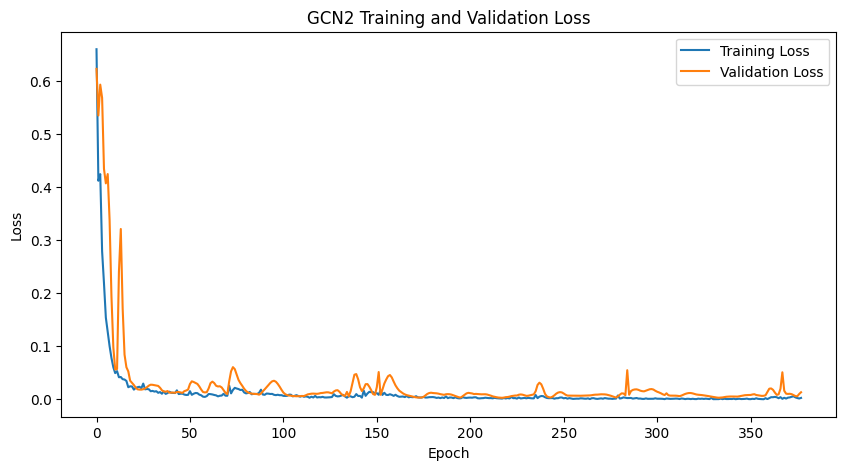


Evaluation on Validation Set:
  Accuracy: 0.998131
  Precision: 0.928571
  Recall: 1.000000
  F1 Score: 0.962963
  AUC: 0.999853
  False Positives: 1
  False Negatives: 0
  Percentage of misinformers identified: 100.00000%

Evaluation on Test Set:
  Accuracy: 0.996279
  Precision: 0.964286
  Recall: 0.900000
  F1 Score: 0.931034
  AUC: 0.999809
  False Positives: 1
  False Negatives: 3
  Percentage of misinformers identified: 90.00000%

Evaluation on Complete Set:
  Accuracy: 0.998509
  Precision: 0.976923
  Recall: 0.962121
  F1 Score: 0.969466
  AUC: 0.999938
  False Positives: 3
  False Negatives: 5
  Percentage of misinformers identified: 96.21212%


In [7]:
csv_file_path = 'users_selected_features.csv'
graph = CreateMessageGraph(csv_file_path)
print(f'Number of nodes: {graph.number_of_nodes()}')
print(f'Number of edges: {graph.number_of_edges()}')

nodes = list(graph.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes)}
pyg_data = from_networkx(graph)

node_features = ExtractNodeFeatures(graph, node_list=nodes)
labels = torch.tensor([graph.nodes[n]['disinformer'] for n in nodes], dtype=torch.long)

data = Data(x=torch.tensor(node_features, dtype=torch.float),
            edge_index=pyg_data.edge_index,
            y=labels)

train_mask, val_mask, test_mask = CreateGraphSplits(graph, node_features, labels, val_ratio=0.10, test_ratio=0.20, random_state=42)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

input_dim = node_features.shape[1]
hidden_dim1 = DEFAULT_HIDDEN_DIM1
hidden_dim2 = DEFAULT_HIDDEN_DIM2
output_dim = 2
dropout_rate = DEFAULT_DROPOUT_RATE
lr = DEFAULT_LEARNING_RATE
weight_decay = DEFAULT_WEIGHT_DECAY

print("\nStarting k-fold cross-validation with GCN2...")
cv_results = KFoldCrossValidation(data, k=5, epochs=300, hidden_dim1=hidden_dim1,
                                 hidden_dim2=hidden_dim2, dropout_rate=dropout_rate, 
                                 lr=lr, weight_decay=weight_decay, gcn2_layers=4)

print("\nTraining final GCN2 model on full training set...")

X_np = node_features
train_idx = data.train_mask.cpu().numpy()
scaler = StandardScaler().fit(X_np[train_idx])
X_scaled = scaler.transform(X_np)
data.x = torch.tensor(X_scaled, dtype=torch.float)

model = GCN2Net(input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate, num_layers=4)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
class_counts = torch.bincount(data.y[data.train_mask])
total_samples = data.train_mask.sum().item()
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts.float().clamp(min=1)))
criterion = torch.nn.NLLLoss(weight=class_weights)

best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
FINAL_EARLY_STOPPING_PATIENCE = 160

train_losses = []
val_losses = []
FINAL_EPOCHS = 400
for epoch in range(FINAL_EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        val_loss = criterion(output[data.val_mask], data.y[data.val_mask])
    val_losses.append(val_loss.item())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= FINAL_EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

if best_model_state:
    model.load_state_dict(best_model_state)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('GCN2 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('gcn2_training_curves.png')
plt.show()

model.eval()
with torch.no_grad():
    output = model(data.x, data.edge_index)
    val_probs = torch.exp(output[data.val_mask])[:, 1].cpu().numpy()
    val_labels = data.y[data.val_mask].cpu().numpy()
threshold = FindBestThreshold(val_labels, val_probs)

val_metrics = EvaluateModel(model, data, data.val_mask, threshold=threshold, dataset_name="Validation Set", return_metrics=True)
test_metrics = EvaluateModel(model, data, data.test_mask, threshold=threshold, dataset_name="Test Set", return_metrics=True)
full_metrics = EvaluateModel(model, data, None, threshold=threshold, dataset_name="Complete Set", return_metrics=True)